# ZMS LAB 043 - case GWINTEX

kontakt: annaszczurek2@gmail.com


## Opis zajęć


Firma GWINTEX S.A. jest międzynarodowym potentatem w dziedzinie produkcji korkociągów. Korkociągi są wytwarzane na bardzo nowoczesnych maszynach metalurgicznych. W związku ze znacznym wzrostem zamówień firma planuje uruchomienie nowej hali produkcyjnej, w której znajdzie się **n=6 maszyn**. Do każdej maszyny jest przypisany operator, który jest odpowiedzialny za jej obsługę oraz usuwanie awarii. Na podstawie pomiarów historycznych wiadomo, że **czas bezawaryjnej pracy maszyny ma rozkład wykładniczy ze średnią 75 minut**. W przypadku wystąpienia awarii operator dzwoni do warsztatu z prośbą o dostarczenie pakietu narzędzi naprawczych. Pakiet narzędzi jest bardzo ciężki i w związku z tym musi być transportowany za pomocą przenośnika taśmowego (taśmociągu). **Czas transportu zestawu narzędzi do maszyny wynosi *ti*, i=1..6. Czas naprawy jest zmienną losową z rozkładu Erlanga k=3 i średnio wynosi 15 minut**. Po ukończeniu naprawy narzędzia są powtórnie umieszczane na taśmociągu i wracają w komplecie do warsztatu celem ich uzupełnienia. Ze względu na specyfikę specjalistycznych narzędzi nie jest możliwe dokonywanie kolejnych napraw przed powrotem narzędzi do warsztatu. Ze względu na bardzo wysoką cenę jednego pakietu narzędzi naprawczych ich liczba ***m* jest mniejsza od liczby maszyn w hali produkcyjnej**. Gdy w danej chwili pakiet narzędzi nie jest dostępny operator czeka aż inny pakiet wróci do warsztatu i zostanie mu wysłany.

Zarząd firmy GWINTEX zastanawia się **jakie powinno być rozmieszczenie urządzeń na hali produkcyjnej** oraz **ile pakietów narzędziowych do obsługi maszyn należy zakupić**. Rozważane są dwie organizacje hali produkcyjnej – układ liniowy oraz układ gniazdowy. **W układzie liniowym czas transportu narzędzi z warsztatu do maszyny wynosi ***ti=i*2***, natomiast **w układzie gniazdowym czas ten jest stały i wynosi 3 minuty**. Czas transportu narzędzi do warsztatu jest taki sam jak czas transportu do maszyny. Wprowadzenie układu gniazdowego wiąże się z wyższymi kosztami instalacyjnymi związanymi z uruchomieniem sześciu niezależnych taśmociągów.




## ROZWIĄZANIE

*author: P*

### 1. Stałe i zmienne wykorzystane w modelu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# liczba maszyn
n = 6 

# średni czas pracy bez usterki
avg_working_time = 75 # minut

# średni czas naprawy
avg_repair_time = 15 # minut

# ilość zestawów narzędzi
m = 2

# horyzont analizy
horizon = 30 # dni

# liczba uruchomień symulacji
iterations = 1000   

In [3]:
# Toolset transport times for all considered setups - this should facilitate easier handling of new
# setups
transport_times = {'L': {i:2*(i+1) for i in range(6)}, 'G': {i:3 for i in range(6)},
                   'L2': {0:2, 1:2, 2:4, 3:4, 4:6, 5:6}}

### 2. Model

Wektory, które mają za zadanie kontrolować stan symulacji:

- momenty wystąpienia kolejnych zdarzeń
- status narzędzi i maszyn 
    - `W` - pracuje 
    - `Q` - czeka na narzedzia 
    - `R` - jest naprawiona
- czas ich bezczynności
- events --> wektor zdarzeń, które zmieniają stan symulacji (np. zepsucie się maszyny, czas naprawy, itp.)

In [4]:
def model(horizon, avg_working_time, avg_repair_time, n, m, setup):
    # setup - układ liniowy "L" lub gniazdowy "G"
    
    # horyzont działania w minutach
    horizon = horizon * 24 * 60 
    
    # wektor zdarzeń, który zmienia stan symulacji
    events = list(np.random.exponential(avg_working_time, n))
    
    # status - określa aktualny stan maszyny 
    status = ["W"] * n

    # t_start - określa początek bezczynności maszyny
    t_start = [0] * n

    # t_cum - skumulowany czas bezczynności maszyny
    t_cum = [0] * n

    # tools_loc lokalizacja narzedzi - albo numer maszyny albo -1 czyli warsztat
    tools_loc = [-1] * m

    # tools_occupied czas zajecia zestawu przez naprawianą maszynę
    tools_occupied = [0] * m
    
    # zegar symulacji- najblizsze zadanie, które ma być wykonane
    t = min(events)
    
    # rozpoczynamy symulacje "skacząc" po kolejnych zdarzeniach  
    while t <= horizon:
        
        # jeżeli zestawy nie są aktualnie zajęte to przenosimy je z powrotem do warsztatu
        for i in range(m):
            if tools_occupied[i] <= t:
                tools_loc[i] = -1

        # wybieramy maszynę, której dotyczy zdarzenie
        machine = events.index(t)
        
        """
        Gdy maszyna, której dotyczy zdarzenie ma status "W":
            - to najpierw zaktualizuj wektor t_start dla tej maszyny jako początek jej bezczynności = t.
            - następnie sprawdź czy dostępny jest jakiś zestaw naprawczy. Jezeli nie:
                - to ustaw status maszyny na "Q" 
                - zaktualizuj wektor events podajac mu najkrótszy czas oczekiwania na wolny zestaw.
              Jeżeli tak:
                - ustaw status maszyny na "R"
                - wyznacz czas  potrzebny na naprawę maszyny w zależności od ukladu taśmociągu 
                (czas transportu + czas naprawy)
                - ustaw koniec naprawy jako zdarzenie dla danej maszyny
                - zaktualizuj wektor tools_loc dla odpowiedniego zestawu podając numer maszyny, którą on obsługuje
                - zaktualizuj wektor tools_occupied czasem jaki mu to zajmie (2* transport + naprawa)
        """
        if status[machine] == "W":
            t_start[machine] = t
            tools = - 1
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            if tools == -1 :
                status[machine] = "Q"
                events[machine] = min(tools_occupied)
            else:
                status[machine] = "R"
                transport_time = transport_times[setup][machine]
                repair_time = np.random.gamma(3, avg_repair_time/3)
                events[machine] += repair_time + transport_time
                tools_loc[tools] = machine
                tools_occupied[tools] += repair_time + 2 * transport_time
                
                """
                Gdy maszyna ma status "Q":
                    - wybierz dostępny zestaw naprawczy
                    - ustal status maszyny na "R"
                    - zaktualizuj wektor tools_loc lokalizacją narzedzi i tools_occupied 
                    czasem jaki zajmie ich transport (w dwie strony) i naprawa maszyny
                    -zaktualizuj wektor zdarzeń czasem potrzebnym na naprawę maszyny i transport narzedzi
                """
                
        elif status[machine] == "Q":
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            status[machine] = "R"
            transport_time = transport_times[setup][machine]
            repair_time = np.random.gamma(3, avg_repair_time/3)
            events[machine] += repair_time + transport_time
            tools_loc[tools] = machine
            tools_occupied[tools] += repair_time + 2 * transport_time 
            """
            Gdy maszyna ma status "R":
                - ustal jej status na "W"
                - wyznacz czas kolejnej awarii i zaktualizuj wektor events
                - wylicz czas bezczynnosci i uzupelnij o niego liste t_cum
            """
            
        else:
            status[machine] = "W"
            events[machine] += np.random.exponential(avg_working_time)
            t_cum[machine] += t - t_start[machine]
        
        # ustalamy nowe t
        t = min(events)
        
    # wynik - liste skumulowanych bezczynnosci dla kazdej z maszyn
    return (t_cum)

### 3. Funkcja do uruchomienia symulacji

Added seed to provide reproducibility of results

In [5]:
def run_model (iterations, horizon, avg_working_time, avg_repair_time, n, m, setup):
    avg_t_cum = []
    for i in range (iterations):
        np.random.seed(i)
        avg_t_cum.append(model( horizon, avg_working_time, avg_repair_time, n, m, setup))
    return list(map(np.mean, np.transpose(avg_t_cum)))


### 3. Symulacja

In [6]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "L")

[8018.694649282109,
 8757.723040266015,
 9459.107596399343,
 10148.612054393932,
 10802.561983894471,
 11434.186267129855]

In [7]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "L")

[8018.694649282109,
 8757.723040266015,
 9459.107596399343,
 10148.612054393932,
 10802.561983894471,
 11434.186267129855]

In [8]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "G")

[8347.564915484105,
 8380.123700064243,
 8355.256106694358,
 8384.153839734714,
 8355.111450984408,
 8341.936466176845]

In [9]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "L2")

[7982.470214492975,
 7982.707444103228,
 8722.963504558775,
 8748.355167298496,
 9449.006820007518,
 9459.140013321161]

### 4. Simplest comparison

In [10]:
import time

In [11]:
t0 = time.clock()
results = {}
for setup in ['L', 'G', 'L2']:
    for m in range(5):
        results[(setup, m+1)] = run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m+1, setup)
print('Entire simulation duration time: {:.1f}s'.format(time.clock() - t0))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Entire simulation duration time: 664.6s


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [12]:
df = pd.DataFrame.from_dict(results).T

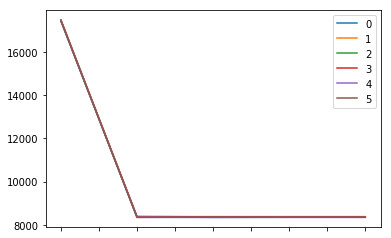

In [13]:
df.loc[('G', slice(None)),:].plot()

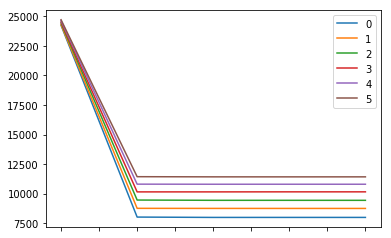

In [14]:
df.loc[('L', slice(None)),:].plot()

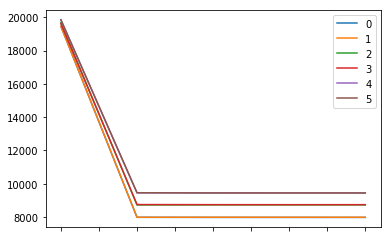

In [15]:
df.loc[('L2', slice(None)),:].plot()

Interestingly, either the simulation code contains some mistakes or buying more than 2 toolkits doesn't materially improve the efficiency.

In [16]:
df2 = df.mean(axis=1).unstack()

Basing on the table above we can approximate various intervals of machine downtime cost at which each solution would be optimal

In [17]:
df2 

,1,2,3,4,5
G,17464.526793,8360.691080,8357.604714,8357.481145,8357.481145
L,24467.989674,9770.147599,9757.190036,9757.330314,9757.089707
L2,19646.098429,8724.107194,8720.785364,8719.789641,8719.800238


In [18]:
df2.loc["L2",:] / df2.loc['L',:]

1    0.802931
2    0.892935
3    0.893780
4    0.893666
5    0.893689
dtype: float64

First observation is that for the initial parametrization, the proposed rearrangement of the linear setup provides at least 10% less machine downtime on average.

In [21]:
df2.loc[:,2:5].values / df2.loc[:,1:4].values

array([[0.47872417, 0.99963085, 0.99998521, 1.        ],
       [0.39930324, 0.99867376, 1.00001438, 0.99997534],
       [0.44406309, 0.99961924, 0.99988582, 1.00000122]])

The table above shows that while buying a second toolkit reduces machine downtime by more than 50%, purchasing more toolkits has almost no impact on total downtime. This will be most likely dependent on average time between failures as well as average repair time - do we want to analyse this relationship?

In [22]:
(df2.loc[:,1].values - df2.loc[:,2].values) / 60

array([151.73059523, 244.96403459, 182.03318725])

In [23]:
(df2.loc['L':'L2',2].values - df2.loc['G',2]) / 60

array([23.49094198,  6.05693524])

<b>Key findings:</b>
- In the current setting, a most-likely optimal scenario would be to purchase 2 toolkits.
- Notably, buying a second toolkit is much more important than changing the setup from linear to spherical/radial (or whatever the proper English name would be). This pays off as long as the cost of a single toolkit is no higher than 245 hours of monthly downtime per machine (181 hours if the modified linear setup can be accommodated).
- Any further improvement would require implementing radial setup instead of the linear one. This is reasonable when the extra cost of implementing this setup doesn't exceed the costs associated with an average of 23.5 hours of downtime per machine (6 if the modified linear setup is feasible).
- Thus, if machine downtime costs is moderate, the recommended solution is to implement the modified linear setup and purchase 2 toolkits. Profits from any further investments will be negligible, unless the cost difference between the spherical and the linear setup is also small.</li>
<br><b>TBA: sensitivity analysis (suggested variables: average time between failures, average repair time, perhaps variance of the repair time)</b>

<b>Issues:</b>
- Since df2.loc['G',4] == df2.loc['G',5] should we be worried about proper seed setting?

<b>Data export</b><br>
<i>So that it is not necessary to run the simulation over and over again to modify a few plots</i>

In [87]:
df.to_hdf('results.hdf', key = 'full_results')
df2.to_hdf('results.hdf', key = 'machine_means')

In [88]:
# Check
if df.equals(pd.read_hdf('results.hdf', key = 'full_results')):
    if df2.equals(pd.read_hdf('results.hdf', key = 'machine_means')):
        print('All DataFrames saved correctly')
    else:
        print('df2 saved/read incorrectly')
else: print('df saved/read incorrectly')

All DataFrames saved correctly


### 5. Some more sensitivity analysis

I assume we use 2 sets of toolkits in all setups

In [26]:
t0 = time.clock()
results_rapair = {}
for setup in ['L', 'G', 'L2']:
    for rapair_improvement in range(5):
        results_rapair[(setup, rapair_improvement)] = run_model(iterations, horizon, avg_working_time, avg_repair_time - rapair_improvement, n, m, setup)
print('Entire simulation duration time: {:.1f}s'.format(time.clock() - t0))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Entire simulation duration time: 825.1s


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [27]:
pd.DataFrame.from_dict(results_rapair)

L                                                          \
              0             1             2             3             4   
0   7990.296703   7595.895883   7214.888876   6799.105025   6381.170445   
1   8750.010651   8365.764031   7982.802490   7605.266637   7200.671065   
2   9435.894596   9091.929129   8730.028098   8373.857329   7986.279963   
3  10152.603575   9795.967046   9435.161024   9093.546899   8731.642935   
4  10795.619747  10464.021512  10145.318639   9800.630999   9452.115550   
5  11419.556609  11115.601100  10824.538011  10478.592340  10141.771324   

             G                                                      \
             0            1            2            3            4   
0  8347.878813  7991.287931  7596.478884  7202.395703  6795.907056   
1  8379.979240  7987.370383  7584.415310  7197.060091  6813.538494   
2  8354.758847  7989.144220  7590.487312  7205.894454  6794.942943   
3  8365.046215  7975.210068  7614.076336  7202.919768  6803.799213   
4  8343.549044  7966.458643  7586.191735  7199.642626  6785.349409   
5  8353.674710  7982.881039  7586.567979  7215.767740  6808.070446   

            L2                                                      
             0            1            2            3            4  
0  7976.440325  7609.959164  7202.274672  6792.353452  6414.947674  
1  7984.652236  7566.232249  7200.716077  6800.109370  6394.019315  
2  8726.619111  8355.841748  7995.093131  7596.278176  7198.720099  
3  8740.533478  8370.442748  7987.926709  7610.520726  7191.691211  
4  9445.317269  9102.396953  8745.243986  8376.278603  7983.296851  
5  9445.175427  9081.915693  8733.843566  8374.494267  7977.704334

In [28]:
df_repair = pd.DataFrame.from_dict(results_rapair).T

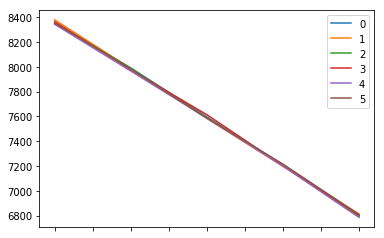

In [29]:
df_repair.loc[('G', slice(None)),:].plot()

Changes in cumulative time while reducing rapiar time by addisional minute

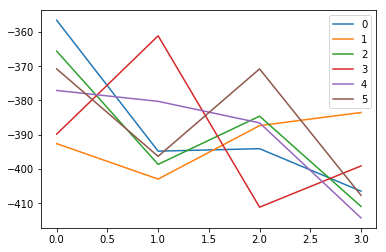

In [30]:
pd.DataFrame(df_repair.loc['G'].iloc[1:,:].values - df_repair.loc['G'].iloc[:4,:].values).plot()

In [31]:
np.mean(df_repair.loc['G'].iloc[1:,:].values - df_repair.loc['G'].iloc[:4,:].values)/60

-6.488388408034242

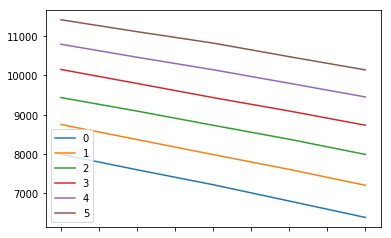

In [32]:
df_repair.loc[('L', slice(None)),:].plot()

Marginal changes

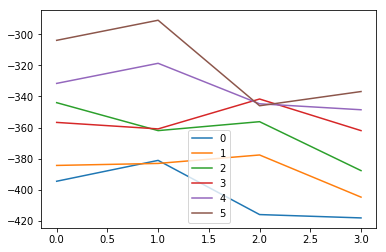

In [33]:
pd.DataFrame(df_repair.loc['L'].iloc[1:,:].values - df_repair.loc['L'].iloc[:4,:].values).plot()

In [34]:
np.mean(df_repair.loc['L'].iloc[1:,:].values - df_repair.loc['L'].iloc[:4,:].values)/60

-6.007174027895564

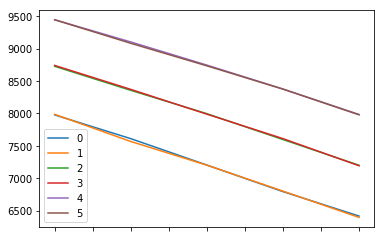

In [35]:
df_repair.loc[('L2', slice(None)),:].plot()

Marginal changes

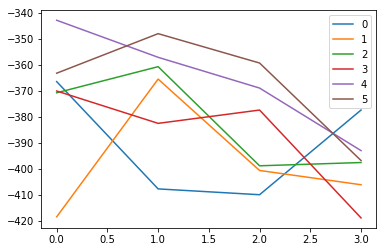

In [36]:
pd.DataFrame(df_repair.loc['L2'].iloc[1:,:].values - df_repair.loc['L2'].iloc[:4,:].values).plot()

In [37]:
np.mean(df_repair.loc['L2'].iloc[1:,:].values - df_repair.loc['L2'].iloc[:4,:].values)/60

-6.359971084927469

It's worth considering extra trainings for workers to make process of repairs faster. As long as it costs of training of one worker to reduce time of repair by 1 minut aren't higher than cost of about 6,4 hours for "L2", 6,3 for "G and 5,9 for "L" it's worth investing as the profits from time reduction seems to be linear

In [89]:
# saving results
df_repair.to_hdf('results_repiar.hdf', key = 'full_results')

In [90]:
# Check
if df_repair.equals(pd.read_hdf('results_repiar.hdf', key = 'full_results')):
    print('All DataFrames saved correctly')
else: 
    print('df saved/read incorrectly')

All DataFrames saved correctly


#### Another analysis

Assuming one toolkit and bad times for company when it needs to reduce production, will it be better to have have "G", "L" or "L2"

In [40]:
t0 = time.clock()
results_machine_reduction = {}
for setup in ['L', 'G', 'L2']:
    for n in range(6):
        n_machines = n + 1
        results_machine_reduction[(setup, n_machines)] = run_model(iterations, horizon, avg_working_time, avg_repair_time, n_machines, m, setup)
print('Entire simulation duration time: {:.1f}s'.format(time.clock() - t0))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Entire simulation duration time: 572.8s


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [41]:
df_machine_reduction = pd.DataFrame.from_dict(results_machine_reduction, orient='index')

In [42]:
df_machine_reduction

,0,1,2,3,4,5
"(L, 1)",7976.359176,NaN,NaN,NaN,NaN,NaN
"(L, 2)",7981.756279,8740.698599,NaN,NaN,NaN,NaN
"(L, 3)",7986.721518,8736.428179,9463.703487,NaN,NaN,NaN
"(L, 4)",7982.982774,8731.269188,9460.895833,10135.044682,NaN,NaN
"(L, 5)",7981.843178,8726.122251,9446.987249,10151.162564,10806.415935,NaN
"(L, 6)",7990.296703,8750.010651,9435.894596,10152.603575,10795.619747,11419.556609
"(G, 1)",8352.805781,NaN,NaN,NaN,NaN,NaN
"(G, 2)",8378.740977,8360.520372,NaN,NaN,NaN,NaN
"(G, 3)",8369.915788,8363.778123,8345.782352,NaN,NaN,NaN
"(G, 4)",8350.320010,8349.587670,8363.786542,8344.886723,NaN,NaN


In [43]:
df_comparison = pd.DataFrame()

In [44]:
df_machine_reduction.iloc[:6,:]

,0,1,2,3,4,5
"(L, 1)",7976.359176,NaN,NaN,NaN,NaN,NaN
"(L, 2)",7981.756279,8740.698599,NaN,NaN,NaN,NaN
"(L, 3)",7986.721518,8736.428179,9463.703487,NaN,NaN,NaN
"(L, 4)",7982.982774,8731.269188,9460.895833,10135.044682,NaN,NaN
"(L, 5)",7981.843178,8726.122251,9446.987249,10151.162564,10806.415935,NaN
"(L, 6)",7990.296703,8750.010651,9435.894596,10152.603575,10795.619747,11419.556609


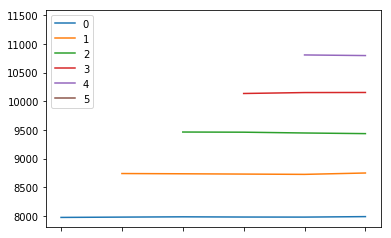

In [45]:
df_machine_reduction.iloc[:6,:].plot()

In [46]:
df_comparison["L"] = df_machine_reduction.iloc[:6,:].mean(axis=1).values

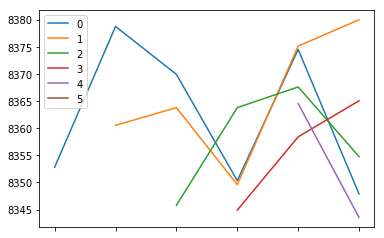

In [47]:
df_machine_reduction.iloc[6:12,:].plot()

In [48]:
df_comparison["G"] = df_machine_reduction.iloc[6:12,:].mean(axis=1).values

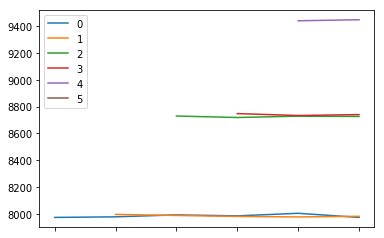

In [49]:
df_machine_reduction.iloc[12:,:].plot()

In [50]:
df_comparison["L2"] = df_machine_reduction.iloc[12:,:].mean(axis=1).values

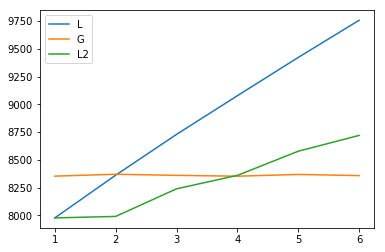

In [51]:
df_comparison = df_comparison.set_index(np.arange(1, 7))
df_comparison.plot()

Assumming 2 toolkits it's better to have "L" if we don't expend big colapse in demand, if we don it may be safer to considere "L2" option as it's not  much worse when 6 machines but when only one is working it's much more effective

In [52]:
df_machine_reduction.to_csv('results_machine_reduction.csv')
df_comparison.to_csv('results_comparison.csv')

In [53]:
pd.read_csv('results_machine_reduction.csv', index_col=0)

,0,1,2,3,4,5
"('L', 1)",7976.359176,NaN,NaN,NaN,NaN,NaN
"('L', 2)",7981.756279,8740.698599,NaN,NaN,NaN,NaN
"('L', 3)",7986.721518,8736.428179,9463.703487,NaN,NaN,NaN
"('L', 4)",7982.982774,8731.269188,9460.895833,10135.044682,NaN,NaN
"('L', 5)",7981.843178,8726.122251,9446.987249,10151.162564,10806.415935,NaN
"('L', 6)",7990.296703,8750.010651,9435.894596,10152.603575,10795.619747,11419.556609
"('G', 1)",8352.805781,NaN,NaN,NaN,NaN,NaN
"('G', 2)",8378.740977,8360.520372,NaN,NaN,NaN,NaN
"('G', 3)",8369.915788,8363.778123,8345.782352,NaN,NaN,NaN
"('G', 4)",8350.320010,8349.587670,8363.786542,8344.886723,NaN,NaN


# Analysis suggested by Paweł

In [63]:
t0 = time.clock()
results_better_machines = {}
for setup in ['L', 'G', 'L2']:
    for working_improvement in range(15):
        results_better_machines[(setup, working_improvement)] = run_model(iterations, horizon, avg_working_time + working_improvement, avg_repair_time, n_machines, m, setup)
print('Entire simulation duration time: {:.1f}s'.format(time.clock() - t0))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Entire simulation duration time: 2368.2s


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [83]:
df_better_machines = pd.DataFrame.from_dict(results_better_machines).T

In [84]:
df_better_machines

0            1            2             3             4  \
L  0   7990.296703  8750.010651  9435.894596  10152.603575  10795.619747   
   1   7909.179789  8649.201482  9363.801668  10053.284412  10707.017121   
   2   7839.919357  8546.983486  9237.324721   9943.112126  10586.485054   
   3   7731.015176  8456.373877  9161.132995   9832.130863  10457.965559   
   4   7647.965331  8385.612763  9061.555025   9764.948588  10386.417212   
   5   7580.156453  8287.338103  8998.118588   9665.473622  10272.892593   
   6   7500.870793  8215.409623  8897.941697   9552.147273  10193.690639   
   7   7438.343424  8119.496799  8788.630897   9468.263455  10105.811009   
   8   7335.004224  8043.822629  8733.894221   9368.242992  10010.689139   
   9   7271.044482  7963.195067  8635.092807   9283.309867   9888.019730   
   10  7213.658868  7912.600972  8552.733454   9203.265979   9807.112737   
   11  7136.544191  7832.040856  8468.797292   9105.933316   9750.405669   
   12  7068.232354  7742.039184  8403.199712   9020.397730   9637.425362   
   13  7009.528544  7671.155893  8332.560062   8956.564364   9565.937953   
   14  6954.508279  7590.933685  8247.774253   8863.454160   9486.093167   
G  0   8347.878813  8379.979240  8354.758847   8365.046215   8343.549044   
   1   8264.884516  8281.920599  8287.269833   8279.164307   8265.471412   
   2   8179.477395  8172.751300  8175.980525   8186.435614   8185.179728   
   3   8077.340939  8088.146578  8092.453924   8105.335245   8078.143265   
   4   8034.657018  7999.784270  8037.590903   8002.946175   8016.667241   
   5   7924.705298  7939.441471  7923.031936   7930.796814   7917.527319   
   6   7859.858214  7849.681515  7863.443778   7842.591435   7867.253619   
   7   7769.485677  7773.992388  7767.162038   7778.020407   7767.620471   
   8   7694.581854  7699.148200  7688.638233   7704.108879   7714.400163   
   9   7625.774837  7639.840825  7630.946587   7616.192804   7620.495068   
   10  7547.340724  7548.291740  7551.276938   7556.006199   7568.931716   
   11  7491.253686  7482.174785  7474.760855   7471.150830   7471.896667   
   12  7410.002340  7425.277138  7395.372073   7387.098100   7411.330151   
   13  7332.181891  7342.705567  7340.201569   7332.212393   7323.676668   
   14  7272.447185  7268.035507  7277.176863   7266.948760   7264.336537   
L2 0   7976.440325  7984.652236  8726.619111   8740.533478   9445.317269   
   1   7871.741064  7904.415851  8637.951002   8638.481230   9345.388116   
   2   7810.817919  7812.179437  8558.363281   8570.720238   9267.346498   
   3   7727.540817  7724.724778  8456.166514   8462.914767   9165.958117   
   4   7651.885995  7643.166974  8383.910693   8386.076615   9068.797258   
   5   7571.133884  7576.295716  8315.295271   8298.228595   8972.674124   
   6   7485.082283  7498.376800  8198.213146   8216.652059   8891.317433   
   7   7425.135642  7420.582131  8120.150357   8138.067658   8799.212434   
   8   7335.914717  7350.474409  8042.224919   8052.257930   8721.553930   
   9   7271.200092  7253.683542  7980.404075   7984.851918   8650.867509   
   10  7189.056384  7195.385789  7879.387060   7895.636892   8572.849520   
   11  7121.248239  7133.129432  7797.562523   7830.841402   8483.033908   
   12  7045.894696  7074.670055  7730.565009   7745.935337   8391.393402   
   13  6997.299835  7004.421099  7668.336135   7687.779565   8329.516852   
   14  6932.696014  6912.227566  7592.441566   7618.832703   8251.027345   

                  5  
L  0   11419.556609  
   1   11320.743921  
   2   11215.652638  
   3   11129.181156  
   4   11005.740860  
   5   10900.976000  
   6   10811.194761  
   7   10694.317304  
   8   10596.411939  
   9   10517.347397  
   10  10430.193161  
   11  10335.514938  
   12  10219.872338  
   13  10129.048752  
   14  10045.873742  
G  0    8353.674710  
   1    8287.224130  
   2    8182.374356  
   3    8107.932607  
   4    8003.942200  
   5    7961.182510  
   6    7855.765918  
   7    7770.8

In [85]:
# saving results
df_better_machines.to_hdf('results_better_machines.hdf', key = 'full_results')

In [86]:
# Check
if df_better_machines.equals(pd.read_hdf('results_better_machines.hdf', key = 'full_results')):
    print('All DataFrames saved correctly')
else: 
    print('df saved/read incorrectly')

All DataFrames saved correctly


In [2]:
df_better_machines = pd.read_hdf('results_better_machines.hdf', key = 'full_results')

In [3]:
df_better_machines

0            1            2             3             4  \
L  0   7990.296703  8750.010651  9435.894596  10152.603575  10795.619747   
   1   7909.179789  8649.201482  9363.801668  10053.284412  10707.017121   
   2   7839.919357  8546.983486  9237.324721   9943.112126  10586.485054   
   3   7731.015176  8456.373877  9161.132995   9832.130863  10457.965559   
   4   7647.965331  8385.612763  9061.555025   9764.948588  10386.417212   
   5   7580.156453  8287.338103  8998.118588   9665.473622  10272.892593   
   6   7500.870793  8215.409623  8897.941697   9552.147273  10193.690639   
   7   7438.343424  8119.496799  8788.630897   9468.263455  10105.811009   
   8   7335.004224  8043.822629  8733.894221   9368.242992  10010.689139   
   9   7271.044482  7963.195067  8635.092807   9283.309867   9888.019730   
   10  7213.658868  7912.600972  8552.733454   9203.265979   9807.112737   
   11  7136.544191  7832.040856  8468.797292   9105.933316   9750.405669   
   12  7068.232354  7742.039184  8403.199712   9020.397730   9637.425362   
   13  7009.528544  7671.155893  8332.560062   8956.564364   9565.937953   
   14  6954.508279  7590.933685  8247.774253   8863.454160   9486.093167   
G  0   8347.878813  8379.979240  8354.758847   8365.046215   8343.549044   
   1   8264.884516  8281.920599  8287.269833   8279.164307   8265.471412   
   2   8179.477395  8172.751300  8175.980525   8186.435614   8185.179728   
   3   8077.340939  8088.146578  8092.453924   8105.335245   8078.143265   
   4   8034.657018  7999.784270  8037.590903   8002.946175   8016.667241   
   5   7924.705298  7939.441471  7923.031936   7930.796814   7917.527319   
   6   7859.858214  7849.681515  7863.443778   7842.591435   7867.253619   
   7   7769.485677  7773.992388  7767.162038   7778.020407   7767.620471   
   8   7694.581854  7699.148200  7688.638233   7704.108879   7714.400163   
   9   7625.774837  7639.840825  7630.946587   7616.192804   7620.495068   
   10  7547.340724  7548.291740  7551.276938   7556.006199   7568.931716   
   11  7491.253686  7482.174785  7474.760855   7471.150830   7471.896667   
   12  7410.002340  7425.277138  7395.372073   7387.098100   7411.330151   
   13  7332.181891  7342.705567  7340.201569   7332.212393   7323.676668   
   14  7272.447185  7268.035507  7277.176863   7266.948760   7264.336537   
L2 0   7976.440325  7984.652236  8726.619111   8740.533478   9445.317269   
   1   7871.741064  7904.415851  8637.951002   8638.481230   9345.388116   
   2   7810.817919  7812.179437  8558.363281   8570.720238   9267.346498   
   3   7727.540817  7724.724778  8456.166514   8462.914767   9165.958117   
   4   7651.885995  7643.166974  8383.910693   8386.076615   9068.797258   
   5   7571.133884  7576.295716  8315.295271   8298.228595   8972.674124   
   6   7485.082283  7498.376800  8198.213146   8216.652059   8891.317433   
   7   7425.135642  7420.582131  8120.150357   8138.067658   8799.212434   
   8   7335.914717  7350.474409  8042.224919   8052.257930   8721.553930   
   9   7271.200092  7253.683542  7980.404075   7984.851918   8650.867509   
   10  7189.056384  7195.385789  7879.387060   7895.636892   8572.849520   
   11  7121.248239  7133.129432  7797.562523   7830.841402   8483.033908   
   12  7045.894696  7074.670055  7730.565009   7745.935337   8391.393402   
   13  6997.299835  7004.421099  7668.336135   7687.779565   8329.516852   
   14  6932.696014  6912.227566  7592.441566   7618.832703   8251.027345   

                  5  
L  0   11419.556609  
   1   11320.743921  
   2   11215.652638  
   3   11129.181156  
   4   11005.740860  
   5   10900.976000  
   6   10811.194761  
   7   10694.317304  
   8   10596.411939  
   9   10517.347397  
   10  10430.193161  
   11  10335.514938  
   12  10219.872338  
   13  10129.048752  
   14  10045.873742  
G  0    8353.674710  
   1    8287.224130  
   2    8182.374356  
   3    8107.932607  
   4    8003.942200  
   5    7961.182510  
   6    7855.765918  
   7    7770.8

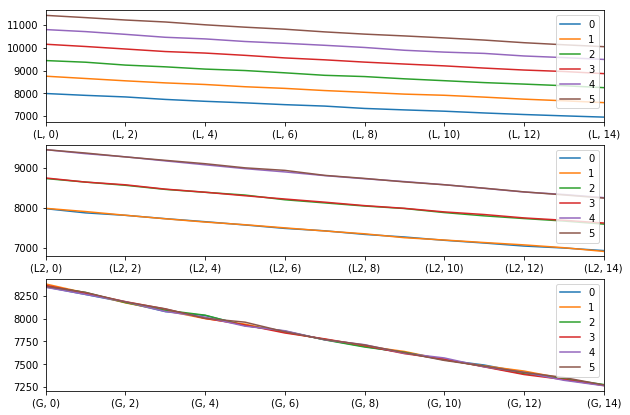

In [11]:
fig, ax = plt.subplots(3, 1, figsize = (10,7))
for x in zip(ax, ['L','L2','G']):
    df_better_machines.loc[(x[1], slice(None)),:].plot(ax = x[0])

Basing on the graph above, the cost improvement from longer time between failures can be well approximated by a linear function

In [17]:
df_better_machines.mean(axis = 1).groupby(level = 0).apply(lambda x: (x.iloc[-1] - x.iloc[0])/len(x))

G    -72.478778
L    -81.726051
L2   -75.235505
dtype: float64

An average improvement in downtime is between 72 and 81 minutes per machine (monthly) for each extra minute of time between failures. From this, the maximum extra cost of higher-quality machines can be inferred.